In [3]:
import os
import warnings
from datetime import datetime
from itertools import product
from tqdm import tqdm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

from dask.distributed import Client
from dask_jobqueue import PBSCluster
from dask.diagnostics import ProgressBar

from src.attrs import PATHS, GLOBALS
from src import utils
from src.data import loading

~/.conda/envs/koopman/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
plt.style.use('custom.mplstyle')

In [8]:
mask_1 = loading.load_north_pacific_mask()
mask_2 = loading.load_north_atlantic_mask()
areas = xr.open_dataarray(os.path.join(PATHS['grid'], 'areas.nc'))

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ssha = loading.load_anomalies('SSH', 1301, '013', chunkedby='time')
    zosa = loading.load_anomalies('zos', 1301, '013', chunkedby='time')
    psla = loading.load_anomalies('PSL', 1301, '013', chunkedby='time')
    
    ssha_1 = ssha.sel(**mask_1.coords)
    zosa_1 = zosa.sel(**mask_1.coords)
    psla_1 = psla.sel(**mask_1.coords)
    eta_iba_1 = ssha_1 - zosa_1
    
    ssha_2 = ssha.sel(**mask_2.coords)
    zosa_2 = zosa.sel(**mask_2.coords)
    psla_2 = psla.sel(**mask_2.coords)
    eta_iba_2 = ssha_2 - zosa_2

In [7]:
with ProgressBar():
    eta_iba_std_1 = eta_iba_1.std(dim='time').load()
    zosa_std_1 = zosa_1.std(dim='time').load()
    ssha_std_1 = ssha_1.std(dim='time').load()

    eta_iba_std_2 = eta_iba_2.std(dim='time').load()
    zosa_std_2 = zosa_2.std(dim='time').load()
    ssha_std_2 = ssha_2.std(dim='time').load()

eta_iba_std_1 = xr.where(mask_1, eta_iba_std_1, np.nan)
zosa_std_1 = xr.where(mask_1, zosa_std_1, np.nan)
ssha_std_1 = xr.where(mask_1, ssha_std_1, np.nan)

eta_iba_std_2 = xr.where(mask_2, eta_iba_std_2, np.nan)
zosa_std_2 = xr.where(mask_2, zosa_std_2, np.nan)
ssha_std_2 = xr.where(mask_2, ssha_std_2, np.nan)

[####                                    ] | 11% Completed | 5.67 sms

~/.conda/envs/koopman/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 59.45 s
[##                                      ] | 6% Completed | 1.52 s ms

~/.conda/envs/koopman/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 12.30 s
[##                                      ] | 6% Completed | 1.51 s ms

~/.conda/envs/koopman/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 12.29 s
[####################                    ] | 50% Completed | 4.23 sms

~/.conda/envs/koopman/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 9.99 s
[##############################          ] | 75% Completed | 3.63 sms

~/.conda/envs/koopman/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 5.24 s
[##############################          ] | 75% Completed | 3.62 sms

~/.conda/envs/koopman/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 5.24 s


In [28]:
covariance_1 = ((zosa_1 - zosa_1.mean(dim='time'))*(eta_iba_1 - eta_iba_1.mean(dim='time'))).mean(dim='time')
covariance_2 = ((zosa_2 - zosa_2.mean(dim='time'))*(eta_iba_2 - eta_iba_2.mean(dim='time'))).mean(dim='time')

In [29]:
with ProgressBar():
    covariance_1.load()
    covariance_2.load()

[########################################] | 100% Completed | 49.73 s
[########################################] | 100% Completed | 14.15 s


~/.conda/envs/koopman/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
~/.conda/envs/koopman/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


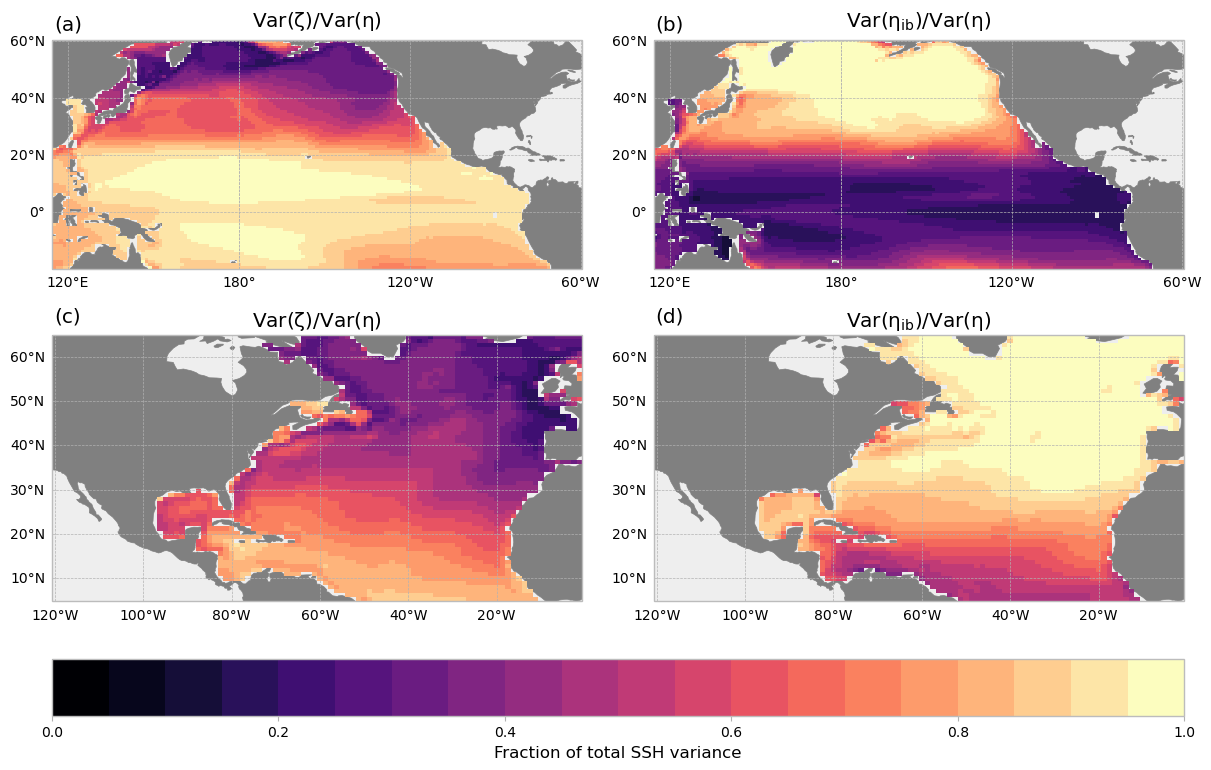

In [30]:
fig, axes = plt.subplot_mosaic(
    [['a', 'b'], ['c', 'd']],
    figsize=(12,8),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
    layout='constrained'
)

cax = (zosa_std_1 / ssha_std_1).plot(
    ax=axes['a'],
    cmap=plt.get_cmap('magma', 20), 
    vmin=0, 
    vmax=1,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cax = (eta_iba_std_1 / ssha_std_1).plot(
    ax=axes['b'],
    cmap=plt.get_cmap('magma', 20), 
    vmin=0, 
    vmax=1,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cax = (zosa_std_2 / ssha_std_2).plot(
    ax=axes['c'],
    cmap=plt.get_cmap('magma', 20), 
    vmin=0, 
    vmax=1,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cax = (eta_iba_std_2 / ssha_std_2).plot(
    ax=axes['d'],
    cmap=plt.get_cmap('magma', 20), 
    vmin=0, 
    vmax=1,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)


########################################################################
# Axis properties
axes['a'].set(
    title=r'$\mathregular{Var(\zeta) / Var(\eta)}$'
)
axes['b'].set(
    title=r'$\mathregular{Var(\eta_{ib}) / Var(\eta)}$'
)
axes['c'].set(
    title=r'$\mathregular{Var(\zeta) / Var(\eta)}$'
)
axes['d'].set(
    title=r'$\mathregular{Var(\eta_{ib}) / Var(\eta)}$'
)

for label, ax in axes.items():
    ax.add_feature(cartopy.feature.LAND, color=(0.5,0.5,0.5))
    gl = ax.gridlines()
    gl.ylabels_left = True
    gl.xlabels_bottom = True
    ax.annotate(f'({label})', xy=(0.03, 1.07), xycoords='axes fraction', ha='center', va='center', fontsize='x-large')
    
cb = plt.colorbar(cax, ax=axes.values(), location='bottom', label='Fraction of total SSH variance')

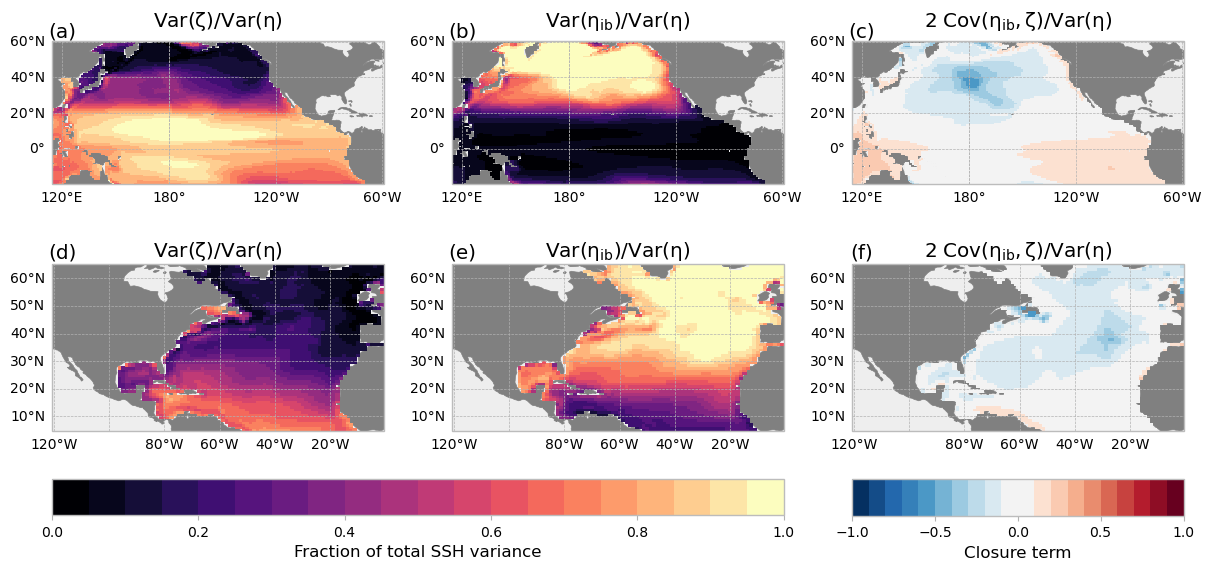

In [78]:
fig, axes = plt.subplot_mosaic(
    [['a', 'b', 'c'], ['d', 'e', 'f']],
    figsize=(12,6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
    per_subplot_kw = {
        'a': {'projection': ccrs.PlateCarree(central_longitude=200)},
        'b': {'projection': ccrs.PlateCarree(central_longitude=200)},
        'c': {'projection': ccrs.PlateCarree(central_longitude=200)},
        'd': {'projection': ccrs.PlateCarree()},
        'e': {'projection': ccrs.PlateCarree()},
        'f': {'projection': ccrs.PlateCarree()},
    },
    layout='constrained'
)

cax_a = ((zosa_std_1 / ssha_std_1)**2).plot(
    ax=axes['a'],
    cmap=plt.get_cmap('magma', 20), 
    vmin=0, 
    vmax=1,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    edgecolor='face'
)

cax_a = ((eta_iba_std_1 / ssha_std_1)**2).plot(
    ax=axes['b'],
    cmap=plt.get_cmap('magma', 20), 
    vmin=0, 
    vmax=1,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    edgecolor='face'
)

cax_a = ((zosa_std_2 / ssha_std_2)**2).plot(
    ax=axes['d'],
    cmap=plt.get_cmap('magma', 20), 
    vmin=0, 
    vmax=1,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    edgecolor='face'
)

cax_a = ((eta_iba_std_2 / ssha_std_2)**2).plot(
    ax=axes['e'],
    cmap=plt.get_cmap('magma', 20), 
    vmin=0, 
    vmax=1,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    edgecolor='face'
)

N = 20
cmap = plt.get_cmap('RdBu_r',N)
colors = cmap(np.linspace(0, 1, N))
max_color = colors[:, 0:2].mean(axis=1).max() 
colors[N // 2 - 1: N // 2 + 1,:] = max_color * np.ones((2,4))
cmap = mpl.colors.ListedColormap(colors)

cax_b = xr.where(mask_1, 2 * covariance_1 / ssha_std_1**2, np.nan).plot(
    ax=axes['c'],
    cmap=cmap,
    vmin=-1, vmax=1, 
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    edgecolor='face'
)

cax_b = xr.where(mask_2, 2 * covariance_2 / ssha_std_2**2, np.nan).plot(
    ax=axes['f'],
    cmap=cmap,
    vmin=-1, vmax=1, 
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    edgecolor='face'
)

########################################################################
# Axis properties
axes['a'].set(
    title=r'$\mathregular{Var(\zeta) / Var(\eta)}$'
)
axes['b'].set(
    title=r'$\mathregular{Var(\eta_{ib}) / Var(\eta)}$'
)
axes['d'].set(
    title=r'$\mathregular{Var(\zeta) / Var(\eta)}$'
)
axes['e'].set(
    title=r'$\mathregular{Var(\eta_{ib}) / Var(\eta)}$'
)
axes['c'].set(
    title=r'$\mathregular{2 \ Cov(\eta_{ib}, \zeta) / Var(\eta)}$'
)
axes['f'].set(
    title=r'$\mathregular{2 \ Cov(\eta_{ib}, \zeta) / Var(\eta)}$'
)

for label, ax in axes.items():
    ax.add_feature(cartopy.feature.LAND, color=(0.5,0.5,0.5))
    gl = ax.gridlines()
    gl.left_labels = True
    gl.bottom_labels = True
    ax.annotate(f'({label})', xy=(0.03, 1.07), xycoords='axes fraction', ha='center', va='center', fontsize='x-large')
    
cb_a = plt.colorbar(
    cax_a,
    ax=[axes['a'], axes['b'], axes['d'], axes['e']],
    location='bottom',
    label='Fraction of total SSH variance'
)
cb_b = plt.colorbar(
    cax_b, 
    ax=[axes['c'], axes['f']],
    location='bottom', 
    aspect=9,
    label='Closure term',
)

plt.savefig(os.path.join(PATHS['visualization'], 'Figures', 'ssh_variability.pdf'))

In [38]:
((zosa_std_1 / ssha_std_1)**2).weighted(areas).mean().item()

0.6767895696472989

In [39]:
((eta_iba_std_1 / ssha_std_1)**2).weighted(areas).mean().item()

0.32347185667524997

In [40]:
((zosa_std_2 / ssha_std_2)**2).weighted(areas).mean().item()

0.3581148670247292

In [41]:
((eta_iba_std_2 / ssha_std_2)**2).weighted(areas).mean().item()

0.7058642915122122